# Integer Quantization

# Prevalence of Floating Point
Today's algorithms for training deep convolutional neural networks rely heavily on floating point arithmetic.  
  
The goal of training is to minimize a multi-variate cost function, which in turn allows the network to make useful predecitions.  
Minimizing this cost function requires making minute updates to network parameters (weights).   
Below is a visualization of training w/ different update methods:

<img src="http://cs231n.github.io/assets/nn3/opt2.gif" alt="Drawing" style="width: 400px;"/>

Floating point data types provide the fine precision that is key for training, however floating point arithmetic is known to be slower and more complex than fixed point arithmetic. When deploying trained networks for inference work loads, it is highly advantageous to employ fixed point arithmetic for the purpose of acceleration, model compression, and power reduction. 


## FP32 vs INT8
Floating point representation is similar to the scientific notation representation we learn growning up.  
Scientific notation is used to represent quantities with huge dynamic range:  
$${\text{mass of the sun}} = 1.99 × 10^{30} kg$$
$${\text{mass of a hydrogen atom}} = 1.67 × 10^{-27} kg$$  

Single precision floating point (FP32) represents real numbers using 32 bits.  

Those bits are subdivided into a sign bit s, 8b exponent e, and a 23b significand:  


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Float_example.svg/590px-Float_example.svg.png "fp32")

$${\displaystyle {\text{value}}=(-1)^{\text{s}}\times 2^{(e-127)}\times \left(1+\sum _{i=1}^{23}b_{23-i}2^{-i}\right).}$$


In comparison, Fixed Point representations are far simpler, and integer types even more so.  

8-bit integers (INT8) represent real numbers using 8 bits.  

The msb has a special significance as it has a negative weight:

![alt text](https://raw.githubusercontent.com/lean-tra/Swift-Korean/master/images/bitshiftsignedminusfour_2x.png "int8")

$${\displaystyle {\text{value}}=-b_{7}2^{7}+\sum _{i=0}^{6}b_{i}2^{i}.}$$

The table below summarizes the important differences, but the theme is that floating point representations require 4x the storage space, require dramatically more hardware resources (Flip-Flops, Logic Gates), require more power, and as a growing body of research shows - are unnecessary for the task of inference.  
  
| Representation | Size (bits) | Max Value | Min Value | Smallest Positive Value |
|----------------|-------------|-----------|-----------|-------------------------|
|FP32|32|$$3.402823 × 10^{38}$$|$$-3.402823 × 10^{38}$$|$$1.175494 × 10^{-38}$$|
|INT8|8|$$127$$|$$-128$$|$$1$$|


# Approximate an FP32 vector with an INT8 vector using Uniform Symmetric Quantization
Given a vector X of floating point values, whose range of elements is well bounded and evenly distributed, the vector can be well represented by integers using uniform symmetric quantization.  
  
Using INT8, we can easily represent the symmetric range {-127:127}

If we can determine a symmetric floating point range {-threshold:+threshold} that bounds the elements of our vector, we can create an affine mapping between the floating point range, and the INT8 range using a scaling factor "sf". 
  
Where:    

$$\mathrm{{sf}_x} = \frac {127}{\mathrm{threshold}}\tag{1}\label{1}$$  
  
$$\mathrm{X_{INT8}} \approx \mathrm{{sf}_x}\,\!\cdot\!\mathrm{{X}_{FP32}}\tag{2}\label{2}$$  
  
Note, that in practice the below equation is actually applied
1. The FP32 vector needs to be clipped before scaling if the threshold is smaller than the range of the vector.  
2. After scaling the result is rounded to values that can be represented as INT8 (Whole number integers) 
  
$$\mathrm{X_{INT8}} = round(\,\mathrm{{sf}_x}\,\!\cdot\!\,clip(\,\mathrm{{X}_{FP32}},-threshold,threshold\,)\,)\tag{3}\label{3}$$  
  
Dequantizing the input is done by reversing the scale operation
$$\mathrm{X_{DEQUANTIZED}} = \frac{ \mathrm{{X}_{INT8}} } { \mathrm{{sf}_x} } \tag{4}\label{4}$$   
  
In the next few cells, we will show you:
1. Quantize an FP32 vector to INT8
2. Compare the two vectors
3. Dequantize the INT8 vector back to FP32
4. Calculate the Error in Quantizing, and Dequantizing.
5. Optionally, you can adjust the chosen threshold to see it's impact.


In [1]:
# Setup
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [2]:
# Define a dictionary to hold data, and meta-data for a vector X
X = {}

# Define random vector A["fp32"] of 100 floating point numbers
X["mu"] = 0     # Mean
X["sigma"] = 1  # Standard deviation
X["fp32"] = X["mu"] + X["sigma"]*np.random.randn(100).astype(np.float32)

In [3]:
# Lets choose the maximum and minimum floating point value to represent
# i.e. we are selecting the range {-threshold:+threshold}
# By default we will set the threshold to the maximum absolute value of the vector
# However, if we believe the vector has outliers, we could select a smaller threshold
mx = np.max(np.abs(X["fp32"]))
@widgets.interact(threshold=(0, mx,0.01))
def f(threshold=mx):
    print "Threshold set to: ",threshold
    X["threshold"] = threshold

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTIuNTUyOTg5NzIxMjk4MjE3OCwgZGVzY3JpcHRpb249dSd0aHJlc2hvbGQnLCBtYXg9Mi41NTI5ODk3MjEyOTgyMTc4LCDigKY=


In [4]:
# Using INT8, the maximum positive value is 127
# So the positive floating point values can be "int8" to or "mapped" to
# one of 128 possible quantization levels (including zero which is also valid)
# To scale from the FP32 range to the INT8 range, we need a scaling factor
# The scaling factor is simiply the ratio of INT8_MAX to the FP32 range we've chosen to represent
# Apply equation (1)
X["sf"] = 127/X["threshold"]

In [5]:
# Apply equation (2)
# First clip the vector, so outlier values will be reduced to the threshold
# Scale input to new range
# Next use a rounding function to convert values to the whole numbers which INT8 can represent
X["int8"] = np.round(X["sf"]*np.clip(X["fp32"],-1*X["threshold"],X["threshold"]))

In [6]:
# Dequantization is acheived by reversing the scale operation that was previously done
# Error is incurred, because we cannot undo the round, or the clip
X["dequantized"] = X["int8"]/X["sf"]

In [7]:
# Calculate the L2 Distance between the original vector, and our recovered vector
l2dist = np.sqrt(np.sum(np.square(X["fp32"] - X["dequantized"])))

# Calculate the percent error of every element
X["perror"] = 100*np.abs((X["dequantized"] - X["fp32"])/(X["fp32"]))

print "The L2 Distance between the FP32 vector, and its Quantized->Dequantized Version is: ",l2dist 

The L2 Distance between the FP32 vector, and its Quantized->Dequantized Version is:  0.057749942


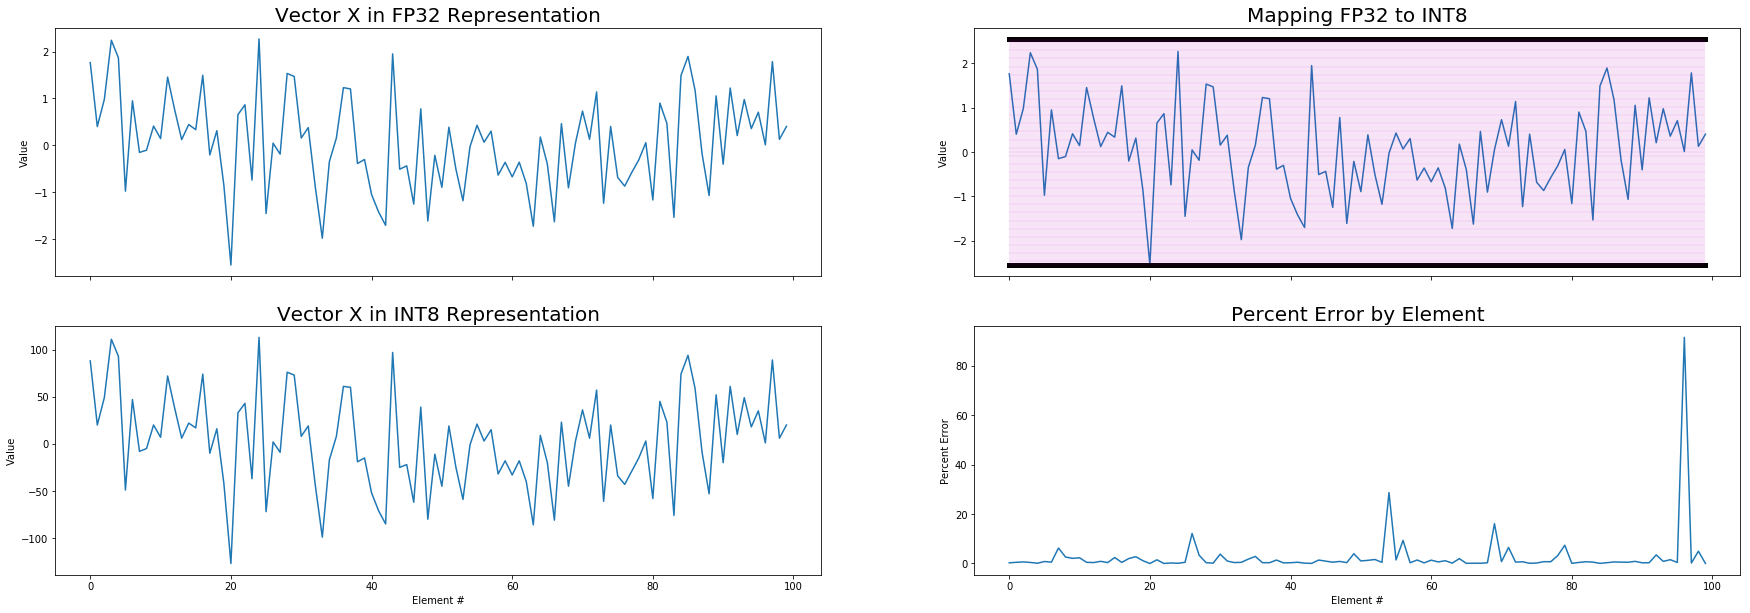

In [8]:
## PLOT EVERYTHING ###
from util import plot_all
plot_all(X)

# Approximate FP32 arithmetic with INT8 arithmetic
## Vector Dot Product Example
Consider the dot product operation + bias of:
$$Y_{FP32} = \vec{W}_{FP32}\,\!\cdot\!\,\vec{X}_{FP32} + B_{FP32}\tag{5}\label{5}$$
  
If we could determine scaling factors sfW and sfX for both W and X where:  
$$\vec{W}_{INT8} \approx \mathrm{{sf}_w}\,\!\cdot\!\vec{W}_{FP32}$$
$$\vec{X}_{INT8} \approx \mathrm{{sf}_x}\,\!\cdot\!\vec{X}_{FP32}$$
  
Then by the multiplication property of equality we would have:  
$${Y}_{INT} \approx {sf}_{w}\!\cdot\!{sf}_{x}\!\cdot\!Y_{FP32} \approx {sf}_{w}\!\cdot\!\vec{W}_{FP32}\!\cdot\!{sf}_{x}\!\cdot\!\vec{X}_{FP32} + {sf}_{w}\!\cdot\!{sf}_{x}\!\cdot\!B_{FP32} \approx \vec{W}_{INT8}\!\cdot\!\vec{X}_{INT8} + {sf}_{w}\!\cdot\!{sf}_{x}\!\cdot\!B_{FP32}\tag{6}\label{6}$$  
  
The dot product needs to be accumulated into a signed integer accumulator wide enough to prevent overflow.  
  
This means if we scale W,X, and B, we can calculate the scaled version of y. Recovering the original value of y, requires reversing the scale, by dividing by the two scale factors:   
  
$${Y}_{DEQUANTIZED} = \frac{{Y}_{INT}}{{sf}_{w}\!\cdot\!{sf}_{x}}\tag{7}\label{7}$$
  
In the next two cells, we will show you:
1. Define an FP32 vector of weights
2. Define an FP32 bias
3. Compute the dot product Y in floating point representation
4. Quantize an FP32 vector of weights to INT8
5. Quantize the Bias
6. Compute the dot product Y in integer representation
7. Dequantize the INT dot product vector back to FP32
8. Calculate the Error between the FP32 calculation and the INT calculation

In [9]:
# Define dictionaries to hold data, and meta-data
W = {}
B = {}
Y = {}

# Define random array W of 100 floating point weights
W["mu"] = 0
W["sigma"] = 0.3
W["fp32"] = W["mu"] + W["sigma"]*np.random.randn(100).astype(np.float32)

# Vector X was defined earlier

# Define random value B as a floating point bias
B["fp32"] = np.random.randn(1).astype(np.float32)

# Calculate Y by taking the dot product of W and X, and adding the bias B
# Apply equation (4)
Y["fp32"] = np.dot(W["fp32"],X["fp32"]) + B["fp32"]

# Y["fp32"] will be the reference that we are trying to approximate with integer arithmetic

In [10]:
# Quantize vector W to INT8
W["threshold"] = np.max(np.abs(W["fp32"]))
W["sf"] = 127/W["threshold"]
W["int8"] = np.round(W["sf"]*np.clip(W["fp32"],-1*W["threshold"],W["threshold"]))

# Vector X is already quantized from earlier

# Quantize the bias B
B["int"] = np.round(W["sf"]*X["sf"]*B["fp32"])

# Calculate Y["int"]
Y["int"] = np.dot(W["int8"],X["int8"]) + B["int"]

# Dequantize Y (Approximation of Y)
Y["dequantized"] = Y["int"]/(W["sf"]*X["sf"])

# Calculate the percent error of every element
Y["perror"] = 100*np.abs((Y["dequantized"] - Y["fp32"])/(Y["fp32"]))

print " Y[fp32] = %f \n Y[int] = %d ; W[sf] = %f ; X[sf] = %f \n Y[dequantized] = %f \n percent_error = %f" \
            %(Y["fp32"][0],Y["int"][0],W["sf"],X["sf"],Y["dequantized"][0],Y["perror"][0])

 Y[fp32] = 3.273381 
 Y[int] = 28619 ; W[sf] = 177.636422 ; X[sf] = 49.745598 
 Y[dequantized] = 3.238678 
 percent_error = 1.060158


# Approximate FP32 arithmetic with INT8 arithmetic
## Matrix Product Example
Consider the Matrix Product operation + bias of:
$$
   Y_{FP32} =  \left[\begin{matrix}
    w_{00} & w_{01} & w_{0j} \\
    w_{10} & w_{11} & w_{1j} \\
    w_{20} & w_{21} & w_{2j} \\
    w_{i0} & w_{i1} & w_{ij} \\
    \end{matrix}\right]\,\!\cdot\!\,
    \left[\begin{matrix}
    x_{00} \\
    x_{10} \\
    x_{j0} \\
    \end{matrix}\right]\, + \,
    \left[\begin{matrix}
    b_{00} \\
    b_{10} \\
    b_{20} \\
    b_{i0} \\
    \end{matrix}\right]
$$

$$Y_{FP32} = \mathrm{W_{FP32}}\!\cdot\!\mathrm{X_{FP32}} + B_{FP32}\tag{8}\label{8}$$
  
If we could determine scaling factors sfW and sfX for both W and X where:  
$${W}_{INT8} \approx \mathrm{{sf}_w}\,\!\cdot\!{W}_{FP32}$$  
$${X}_{INT8} \approx \mathrm{{sf}_x}\,\!\cdot\!{X}_{FP32}$$  
  
Then by the multiplication property of equality we would have:  
$${Y}_{INT} \approx {sf}_{w}\!\cdot\!{sf}_{x}\!\cdot\!Y_{FP32} \approx {sf}_{w}\!\cdot\!{W}_{FP32}\!\cdot\!{sf}_{x}\!\cdot\!{X}_{FP32} + {sf}_{w}\!\cdot\!{sf}_{x}\!\cdot\!B_{FP32} \approx {W}_{INT8}\!\cdot\!{X}_{INT8} + {sf}_{w}\!\cdot\!{sf}_{x}\!\cdot\!B_{FP32}\tag{9}\label{9}$$  

  
The matrix product needs to be accumulated into a signed integer accumulators wide enough to prevent overflow.  
  
This means if we scale W,X, and B, we can calculate the scaled version of y. Recovering the original value of y, requires reversing the scale, by dividing by the two scale factors:   

$${Y}_{DEQUANTIZED} = \frac{{Y}_{INT}}{{sf}_{w}\!\cdot\!{sf}_{x}}\tag{10}\label{10}$$
  
In the next two cells, we will show you:
1. Define an FP32 matrix of weights
2. Define an FP32 matrix of bias (Ok, its a vector, but also a matrix with one row)
3. Compute the matrix product w/ bias in floating point representation (For reference)
4. Quantize an FP32 matrix of weights to INT8
5. Quantize the Bias matrix
6. Compute the matrix product Y in integer representation
7. Dequantize the INT matrix product back to FP32
8. Calculate the Error between the FP32 calculation and the INT calculation

In [11]:
# Define dictionaries to hold data, and meta-data
W = {}
B = {}
Y = {}

# Define random matrix W of 10,000 floating point weights shaped (100x100)
W["mu"] = 0
W["sigma"] = 0.3
W["fp32"] = W["mu"] + W["sigma"]*np.random.randn(100*100).astype(np.float32).reshape(100,100)

# Vector X was defined earlier

# Define random matrix B as a floating point bias
B["fp32"] = np.random.randn(100).astype(np.float32).reshape(1,100)

# Calculate Y by taking the dot product of W and X, and adding the bias B
# Apply equation (4)
Y["fp32"] = np.dot(W["fp32"],X["fp32"]) + B["fp32"]

# Y["fp32"] will be the reference that we are trying to approximate with integer arithmetic

In [12]:
# Quantize matrix W to INT8
W["threshold"] = np.max(np.abs(W["fp32"]))
W["sf"] = 127/W["threshold"]
W["int8"] = np.round(W["sf"]*np.clip(W["fp32"],-1*W["threshold"],W["threshold"]))

# Vector X is already quantized from earlier

# Quantize the bias B
B["int"] = np.round(W["sf"]*X["sf"]*B["fp32"])

# Calculate Y["int"]
Y["int"] = np.dot(W["int8"],X["int8"]) + B["int"]

# Dequantize Y (Approximation of Y)
Y["dequantized"] = Y["int"]/(W["sf"]*X["sf"])

# Calculate the L2 Distance between the original vector, and our recovered vector
l2dist = np.sqrt(np.sum(np.square(Y["fp32"] - Y["dequantized"])))

# Calculate the percent error of every element
Y["perror"] = 100*np.abs((Y["dequantized"] - Y["fp32"])/(Y["fp32"]))

print "The L2 Distance between the FP32 calculation, and its INT->Dequantized Version is: ",l2dist 

The L2 Distance between the FP32 calculation, and its INT->Dequantized Version is:  0.33877662


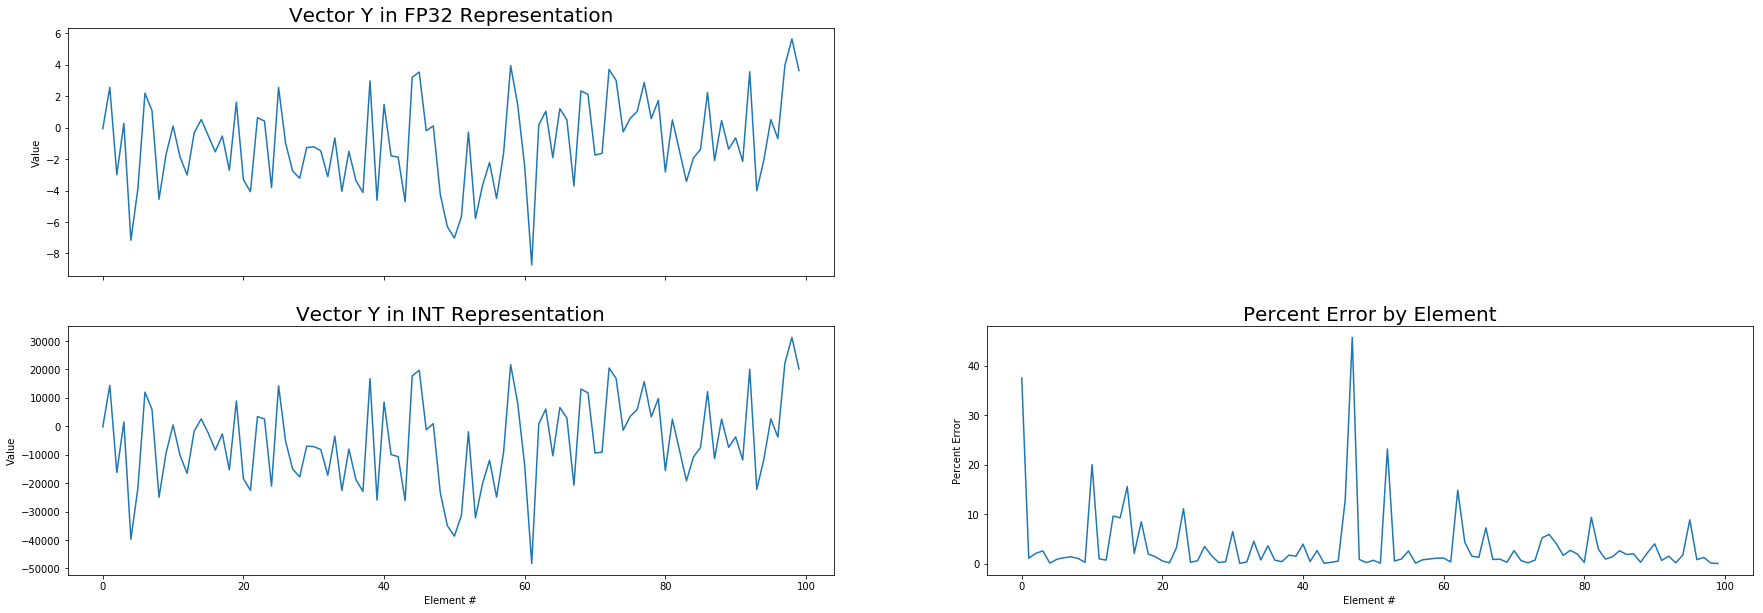

In [13]:
from util import plot_all2
plot_all2(Y)

# Approximate FP32 arithmetic with INT8 arithmetic
## Cascaded Matrix Products Example
Consider the Matrix Products operations + bias of:

$$Z_{FP32} = \mathrm{W0_{FP32}}\!\cdot\!\mathrm{X_{FP32}} + \mathrm{B0_{FP32}}\tag{11}\label{11}$$
  
$$A_{FP32} = ReLU(Z_{FP32})$$
  
$$Y_{FP32} = \mathrm{W1_{FP32}}\!\cdot\!\mathrm{A_{FP32}} +  \mathrm{B1_{FP32}}\tag{12}\label{12}$$
  
If we could determine the following scaling factors where:  
$${W0}_{INT8} \approx \mathrm{{sf}_{w0}}\,\!\cdot\!{W0}_{FP32}$$
$${X}_{INT8} \approx \mathrm{{sf}_x}\,\!\cdot\!{X}_{FP32}$$
$${W1}_{INT8} \approx \mathrm{{sf}_{w1}}\,\!\cdot\!{W1}_{FP32}$$
$${A}_{INT8} \approx \mathrm{{sf}_a}\,\!\cdot\!{A}_{FP32}$$
  
Then by the multiplication property of equality we would have:  
  
$${Z}_{INT} \approx {sf}_{w0}\!\cdot\!{sf}_{x}\!\cdot\!Z_{FP32} \approx {sf}_{w0}\!\cdot\!\mathrm{{W0}_{FP32}}\!\cdot\!{sf}_{x}\!\cdot\!\mathrm{{X}_{FP32}} + {sf}_{w0}\!\cdot\!{sf}_{x}\!\cdot\!\mathrm{B0_{FP32}} \approx \mathrm{{W0}_{INT8}}\!\cdot\!\mathrm{{X}_{INT8}} + {sf}_{w0}\!\cdot\!{sf}_{x}\!\cdot\!\mathrm{B0_{FP32}}\tag{13}\label{13}$$  

$$A_{INT} = ReLU(Z_{INT})$$
  
Need to adjust the larger integer to int8 range for next layer  
Effectively the below scale needs to be acheived  
INT -> FP32 -> INT8  
However, we can acheive the same scalings without converting back to FP32 in integer hardware
$$A_{INT8} = \frac{{sf}_{a}}{{sf}_{w0}\!\cdot\!{sf}_{x}}\!\cdot\!A_{INT}\tag{14}\label{14}$$ 
   
$${Y}_{INT} \approx {sf}_{w1}\!\cdot\!{sf}_{a}\!\cdot\!Y_{FP32} \approx \mathrm{W1_{INT8}}\!\cdot\!A_{INT8} + {sf}_{w1}\!\cdot\!{sf}_{a}\!\cdot\!\mathrm{B1_{FP32}}\tag{15}\label{15}$$ 
  
Recovering the original value of y, requires reversing the scale, by dividing by the two scale factors:   
  
$${Y}_{DEQUANTIZED} = \frac{{Y}_{INT}}{{sf}_{w1}\!\cdot\!{sf}_{a}}\tag{16}\label{16}$$
  
In the next two cells, we will show you:
1. Define two FP32 matricies of weights
2. Define two FP32 matricies of bias (Ok, its a vector, but also a matrix with one row)
3. Compute the matrix products w/ bias in floating point representation (For reference)
4. Quantize two FP32 matricies of weights to INT8
5. Quantize the Bias matricies
6. Compute the product Y in integer representation
7. Dequantize the INT matrix product back to FP32
8. Calculate the Error between the FP32 calculation and the INT calculation

In [14]:
# Define dictionaries to hold data, and meta-data
W0 = {}
W1 = {}
B0 = {}
B1 = {}
Z = {}
A = {}
Y = {}

# Define random matrix W0 of 10,000 floating point weights shaped (100x100)
W0["mu"] = 0
W0["sigma"] = 0.3
W0["fp32"] = W0["mu"] + W0["sigma"]*np.random.randn(100*100).astype(np.float32).reshape(100,100)

# Define random matrix W1 of 10,000 floating point weights shaped (100x100)
W1["mu"] = 0
W1["sigma"] = 0.5
W1["fp32"] = W1["mu"] + W1["sigma"]*np.random.randn(100*100).astype(np.float32).reshape(100,100)

# Vector X was defined earlier

# Define random matrix B0 as a floating point bias
B0["fp32"] = np.random.randn(100).astype(np.float32).reshape(1,100)

# Define random matrix B1 as a floating point bias
B1["fp32"] = np.random.randn(100).astype(np.float32).reshape(1,100)

# Calculate Y by taking the dot product of W and X, and adding the bias B
# Apply equation (4)
Z["fp32"] = np.dot(W0["fp32"],X["fp32"]) + B0["fp32"]
A["fp32"] = np.maximum(Z["fp32"],0)
Y["fp32"] = np.dot(W1["fp32"],A["fp32"].T) + B1["fp32"]

# Y["fp32"] will be the reference that we are trying to approximate with integer arithmetic

In [15]:
# Quantize matrix W0 to INT8
W0["threshold"] = np.max(np.abs(W0["fp32"]))
W0["sf"] = 127/W0["threshold"]
W0["int8"] = np.round(W0["sf"]*np.clip(W0["fp32"],-1*W0["threshold"],W0["threshold"]))

# Quantize matrix W1 to INT8
W1["threshold"] = np.max(np.abs(W1["fp32"]))
W1["sf"] = 127/W1["threshold"]
W1["int8"] = np.round(W1["sf"]*np.clip(W1["fp32"],-1*W1["threshold"],W1["threshold"]))

# Vector X is already quantized from earlier

# Since A is the input to the next layer, we need to quantize it to 8b
# Assumption made here is that the multiplier in hardware can only take 8b operands
# Thus we need a scale factor
A["threshold"] = np.max(np.abs(A["fp32"]))
A["sf"] = 127/A["threshold"]

# Quantize the bias B0
B0["int"] = np.round(W0["sf"]*X["sf"]*B0["fp32"])

# Quantize the bias B1
B1["int"] = np.round(W1["sf"]*A["sf"]*B1["fp32"])

# Calculate Z["int"] - matrix product + bias
Z["int"] = np.dot(W0["int8"],X["int8"]) + B0["int"]

# Calculate A["int"] - ReLU
A["int"] = np.maximum(Z["int"],0)

# Adjust A
# A was an integer accumulator, you could assume the width to be 32b; INT32
# We need to dequantize it back to floating point (Divide by the scaling factors of the inputs)
# We need to quantize it to INT8 for use in the next layer's multiplier (Multiply by scaling factor for next layer)
# This creates an adjustment factor
A["adjustment"] = A["sf"]/(W0["sf"]*X["sf"])

# The challenge posed now is to do this manipulation in the integer domain
# There are several options to acheive this, but here we will simply do an integer multiply,
# followed by a right shift
# These shift and scale parameters are found heuristically offline before the computation is performed, 
# just like the scale factors
from util import findShiftScale
shift,scale = findShiftScale(A["adjustment"])
A["int8"] = scale*A["int"] # Integer will be multiplied
A["int8"] = np.power(2,shift)*A["int8"] # Shift out the unnecessary bits

# Calculate Y["int"]
Y["int"] = np.dot(W1["int8"],A["int8"].T) + B1["int"]

# Dequantize Y (Approximation of Y)
Y["dequantized"] = Y["int"]/(W1["sf"]*A["sf"])

# Calculate the L2 Distance between the original vector, and our recovered vector
l2dist = np.sqrt(np.sum(np.square(Y["fp32"] - Y["dequantized"])))

# Calculate the percent error of every element
Y["perror"] = 100*np.abs((Y["dequantized"] - Y["fp32"])/(Y["fp32"]))

print "The L2 Distance between the FP32 calculation, and its INT->Dequantized Version is: ",l2dist 

The L2 Distance between the FP32 calculation, and its INT->Dequantized Version is:  19.135662


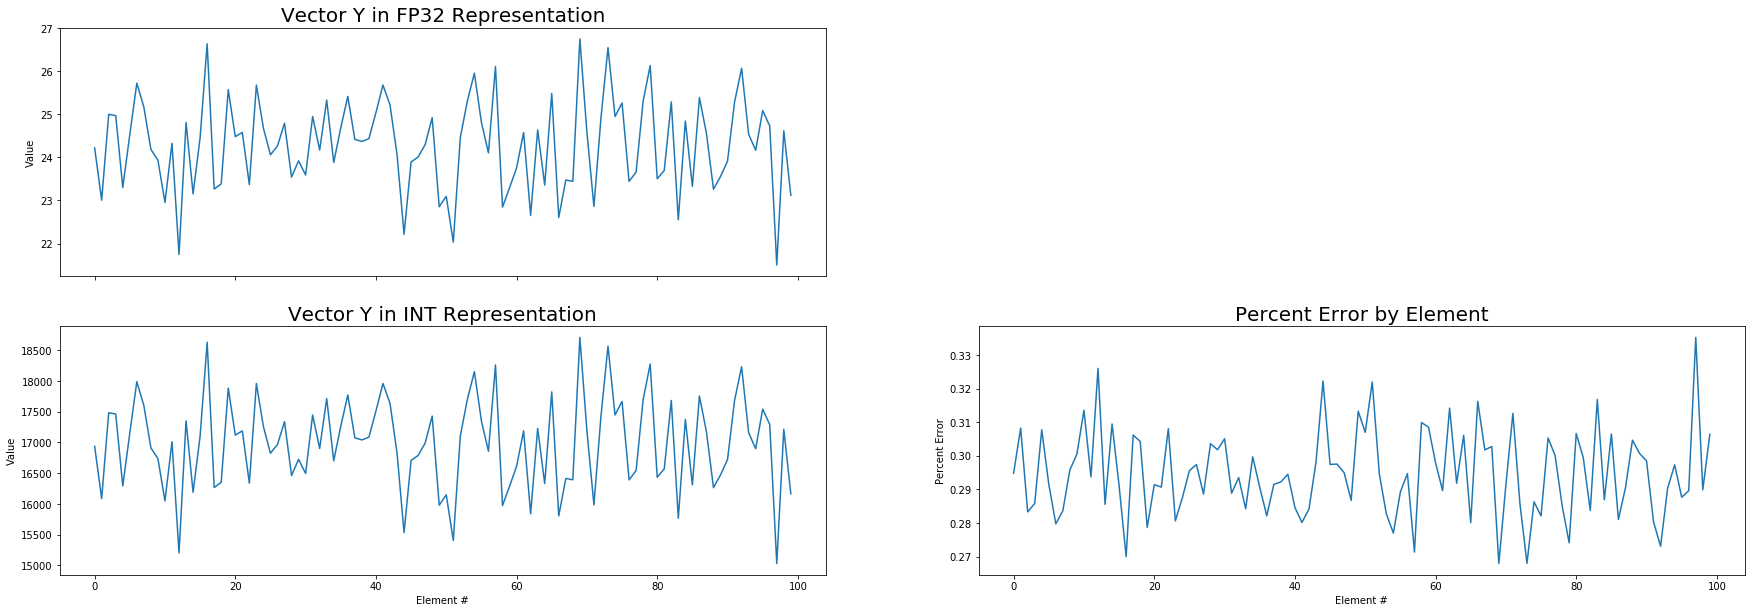

In [16]:
from util import plot_all2
plot_all2(Y)